# Model - CIC IoT 2023 Dataset for Cybersecurity Research

[University of New Brunswick - Canadian Institute for Cybersecurity](https://www.unb.ca/cic/datasets/index.html)

TODOs:
- Test first layer as a binary classification (attack/benign)
- Test limiting weights
- Test dropping Protocol feature
- Test adding a feature indicating the highest protocol layer

# Imports

In [1]:
import os
import sys
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from IPython.display import HTML

sys.path.append('../')
n_jobs = 40

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from lightgbm import LGBMClassifier

## Definitions

In [3]:
import utils
import model_utils
import visualization as viz

from multi_stage_classifier import MultiStageClassifier, ModelStage

constants = utils.get_constants()
seed = constants['seed']

parquet_path = constants['parquet_path']
refined_parquet_path = constants['refined_parquet_path']

features = constants['features']
protocol_layer = constants['protocol_layer']
protocol_layer_map = constants['protocol_layer_map']
attack_category = constants['attack_category']
attack_category_map = constants['attack_category_map']

## Read datasets

In [4]:
df = pd.read_parquet(parquet_path)
df_refined = pd.read_parquet(refined_parquet_path)

features_list = utils.get_features_list(df)
refined_features_list = utils.get_features_list(df_refined)

features_list.remove('Protocol Type')
refined_features_list.remove('Protocol Type')

# Baseline

## Binary Classification - Attack / Benign flow

In [46]:
%%time

is_attack = (df.general_label != 'Benign').map({
    True: 'Attack',
    False: 'Benign'
}).astype('category')

baseline_binary_df_split = model_utils.get_train_test_split(
    df,
    target=is_attack,
    sample_size=2_000_000,
    train_frac=0.80
)

Training dataset size: 1.6M (80.0%).
Test dataset size: 400.0k (20.0%).
CPU times: user 11.5 s, sys: 2.04 s, total: 13.6 s
Wall time: 13.6 s


Execution time (Model fit): 0:00:25.566785
Execution time (Predict): 0:00:01.738790
              precision    recall  f1-score   support

      Attack      0.999     0.998     0.999    390680
      Benign      0.934     0.955     0.944      9320

    accuracy                          0.997    400000
   macro avg      0.966     0.977     0.971    400000
weighted avg      0.997     0.997     0.997    400000

CPU times: user 8min 10s, sys: 5.17 s, total: 8min 15s
Wall time: 1min 21s


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestClassifier(n_jobs=40, random_state=6958))])

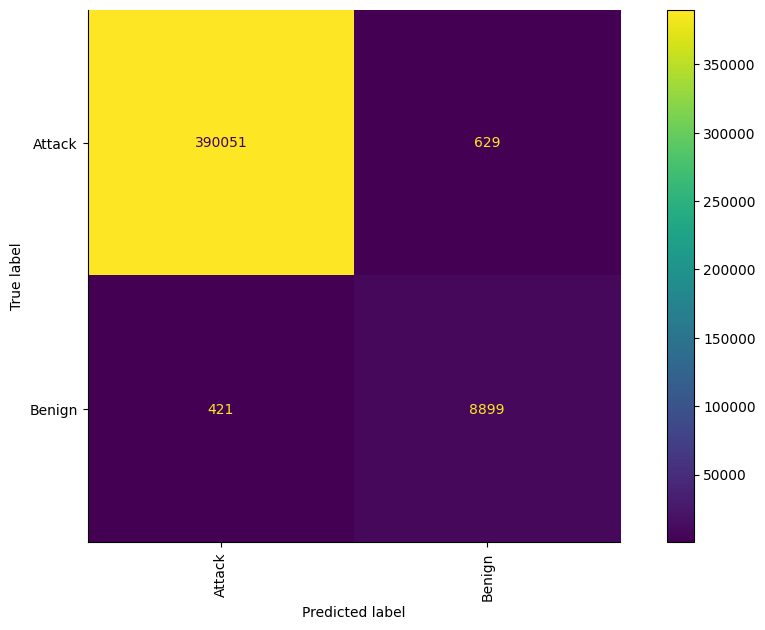

In [47]:
%%time

model_binary_baseline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(n_jobs=n_jobs, random_state=seed))
])

model_utils.test_model(model_binary_baseline, *baseline_binary_df_split)

## 7+1 Classes

In [7]:
%%time

baseline_binary_df_split = model_utils.get_train_test_split(
    df,
    target='general_label',
    sample_size=2_000_000,
    train_frac=0.80
)

Training dataset size: 1.6M (80.0%).
Test dataset size: 400.0k (20.0%).
CPU times: user 5.24 s, sys: 2.6 s, total: 7.83 s
Wall time: 7.83 s


Execution time (Model fit): 0:00:30.138656
Execution time (Predict): 0:00:02.208388
              precision    recall  f1-score   support

      Benign      0.910     0.973     0.940      9644
  BruteForce      1.000     0.315     0.479       124
        DDoS      1.000     1.000     1.000    291017
         DoS      1.000     1.000     1.000     69337
       Mirai      1.000     1.000     1.000     22535
       Recon      0.888     0.790     0.836      3035
    Spoofing      0.882     0.852     0.867      4120
         Web      0.889     0.213     0.343       188

    accuracy                          0.996    400000
   macro avg      0.946     0.768     0.808    400000
weighted avg      0.996     0.996     0.995    400000

CPU times: user 10min 17s, sys: 5.3 s, total: 10min 23s
Wall time: 1min 14s


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestClassifier(n_jobs=40, random_state=6958))])

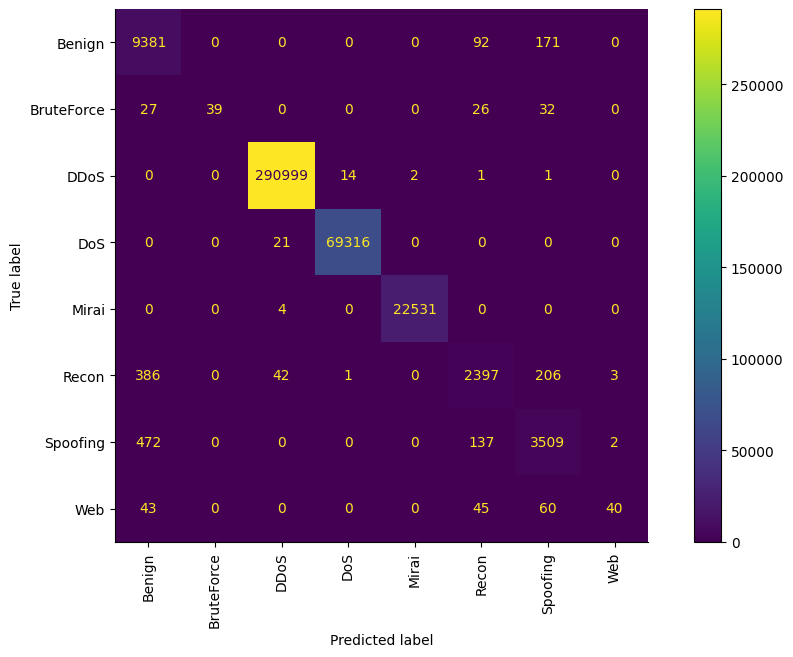

In [18]:
%%time

model_attack_class_baseline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(n_jobs=n_jobs, random_state=seed))
])

model_utils.test_model(model_attack_class_baseline, *baseline_binary_df_split)

# Model (2 Layers)

## First Stage - DDoS / DoS / Mirai

Here we focus on recall... **TODO: Explain why**

In [13]:
%%time

first_layer = {'DDoS', 'DoS', 'Mirai'}
first_stage_labels = df_refined.general_label.where(df_refined.general_label.isin(first_layer), 'Benign').astype('category').cat.remove_unused_categories()

first_stage_df_split = model_utils.get_train_test_split(
    df_refined,
    target=first_stage_labels,
    sample_size=2_000_000,
    train_frac=0.80
)

Training dataset size: 1.6M (80.0%).
Test dataset size: 400.0k (20.0%).
CPU times: user 6.78 s, sys: 1.83 s, total: 8.61 s
Wall time: 8.6 s


Execution time (Model fit): 0:00:33.072352
Execution time (Predict): 0:00:00.586818
              precision    recall  f1-score   support

      Benign      1.000     0.999     0.999     16887
        DDoS      1.000     1.000     1.000    291317
         DoS      1.000     1.000     1.000     69187
       Mirai      1.000     1.000     1.000     22609

    accuracy                          1.000    400000
   macro avg      1.000     1.000     1.000    400000
weighted avg      1.000     1.000     1.000    400000

CPU times: user 13min 24s, sys: 5.43 s, total: 13min 30s
Wall time: 1min 16s


Pipeline(steps=[('model',
                 RandomForestClassifier(class_weight='balanced',
                                        max_features=10, n_jobs=40,
                                        random_state=6958))])

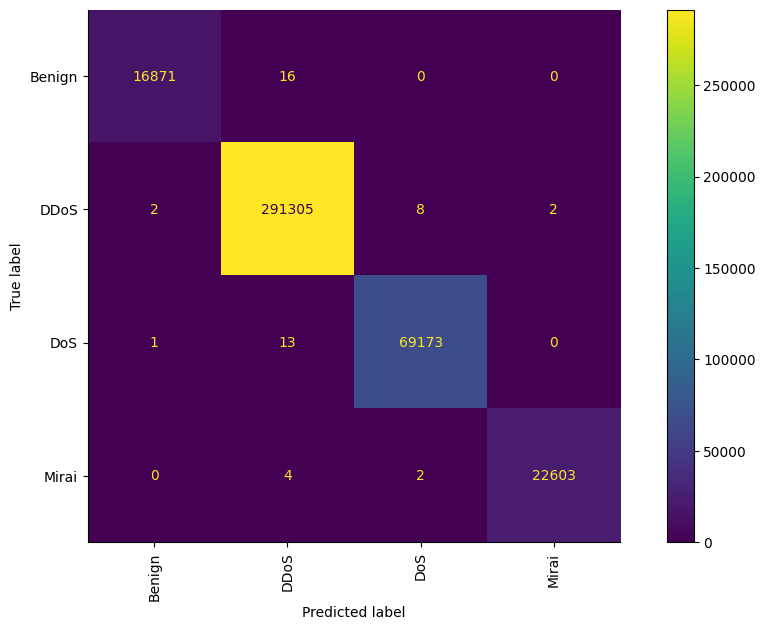

In [16]:
%%time

first_stage_model = Pipeline([
    ('model', RandomForestClassifier(max_features=10, class_weight='balanced', n_jobs=n_jobs, random_state=seed))
])

model_utils.test_model(first_stage_model, *first_stage_df_split)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Execution time (Model fit): 0:00:11.448774
Execution time (Predict): 0:00:00.288250
              precision    recall  f1-score   support

      Benign      1.000     1.000     1.000     16887
        DDoS      1.000     1.000     1.000    291317
         DoS      0.999     1.000     0.999     69187
       Mirai      1.000     1.000     1.000     22609

    accuracy                          1.000    400000
   macro avg      1.000     1.000     1.000    400000
weighted avg      1.000     1.000     1.000    400000

CPU times: user 5min 16s, sys: 505 ms, total: 5min 17s
Wall time: 54.3 s


Pipeline(steps=[('model',
                 LGBMClassifier(class_weight='balanced', n_jobs=40,
                                random_state=6958, verbose=0))])

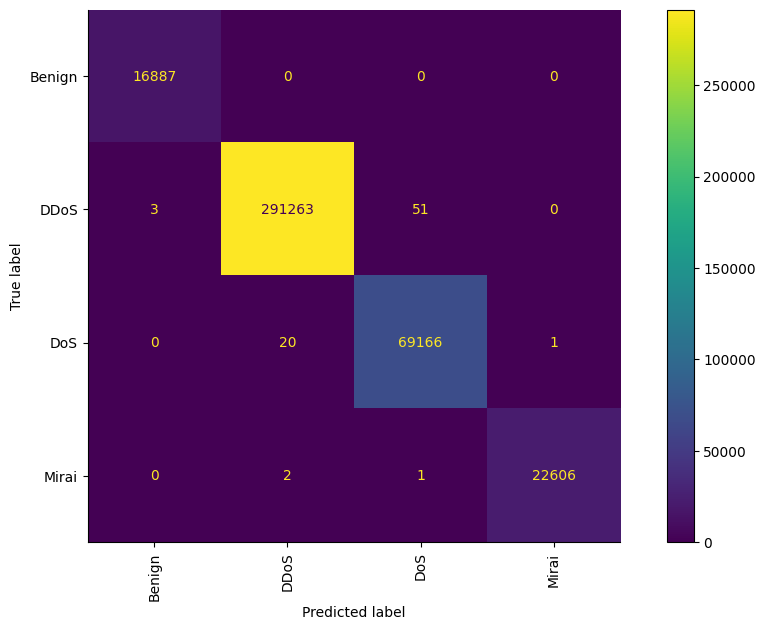

In [17]:
%%time

first_stage_model = Pipeline([
    ('model', LGBMClassifier(class_weight='balanced', n_jobs=n_jobs, random_state=seed, verbose=0))
])

model_utils.test_model(first_stage_model, *first_stage_df_split)

## Second Layer - Spoofing / Recon / Web / Brute Force

In [37]:
%%time

second_layer = {'Spoofing', 'Recon', 'Web', 'BruteForce'}
df_second_layer = df_refined[~df_refined.general_label.isin(first_layer)]
second_layer_target = df_second_layer.general_label.where(df_second_layer.general_label.isin(second_layer), 'Benign').astype('category').cat.remove_unused_categories()

second_stage_df_split = model_utils.get_train_test_split(
    df_second_layer,
    target=second_layer_target,
    train_frac=0.80
)

Training dataset size: 1.6M (80.0%).
Test dataset size: 395.4k (20.0%).
CPU times: user 1.01 s, sys: 204 ms, total: 1.21 s
Wall time: 1.21 s


Execution time (Model fit): 0:01:11.496639
Execution time (Predict): 0:00:00.809437
              precision    recall  f1-score   support

      Benign      0.933     0.981     0.956    219566
  BruteForce      0.991     0.614     0.758      2616
       Recon      0.915     0.868     0.891     70611
    Spoofing      0.932     0.888     0.909     97793
         Web      0.976     0.577     0.725      4846

    accuracy                          0.930    395432
   macro avg      0.949     0.786     0.848    395432
weighted avg      0.930     0.930     0.929    395432



Pipeline(steps=[('model',
                 RandomForestClassifier(max_features=10, n_jobs=40,
                                        random_state=6958))])

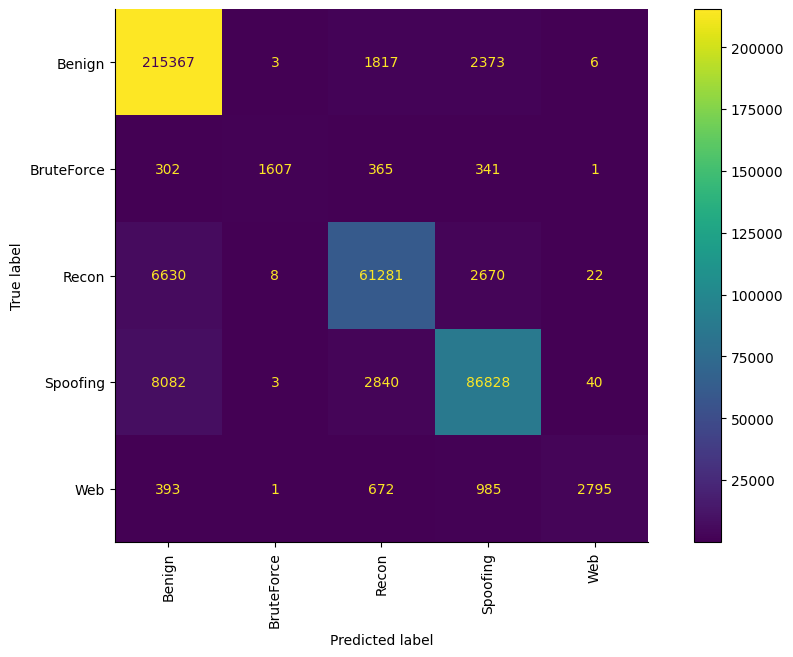

In [39]:
%%time

second_stage_model = Pipeline([
    ('model', RandomForestClassifier(max_features=10, n_jobs=n_jobs, random_state=seed))
])

model_utils.test_model(second_stage_model, *second_stage_df_split)

# Multi-Stage Model

In [42]:
%%time

multi_stage_df_split = model_utils.get_train_test_split(
    df_refined,
    target='general_label',
    sample_size=10_000_000,
    train_frac=0.80
)

Training dataset size: 8.0M (80.0%).
Test dataset size: 2.0M (20.0%).
CPU times: user 12.1 s, sys: 2 s, total: 14.1 s
Wall time: 14.1 s


Execution time (Model fit): 0:03:23.522787
Execution time (Predict): 0:00:03.315082
              precision    recall  f1-score   support

      Benign      0.927     0.979     0.953     47270
  BruteForce      0.994     0.599     0.747       548
        DDoS      1.000     1.000     1.000   1455958
         DoS      1.000     1.000     1.000    346488
       Mirai      1.000     1.000     1.000    112694
       Recon      0.911     0.856     0.883     15162
    Spoofing      0.927     0.878     0.902     20857
         Web      0.989     0.537     0.696      1023

    accuracy                          0.997   2000000
   macro avg      0.968     0.856     0.897   2000000
weighted avg      0.997     0.997     0.997   2000000

CPU times: user 1h 23min 32s, sys: 49.3 s, total: 1h 24min 21s
Wall time: 7min 25s


MultiStageClassifier(stages=[ModelStage(model=RandomForestClassifier(class_weight='balanced', max_features=10, n_jobs=40,
                       random_state=6958), labels={'DoS', 'Mirai', 'DDoS'}),
                             ModelStage(model=RandomForestClassifier(max_features=10, n_jobs=40, random_state=6958), labels={'Benign', 'Recon', 'BruteForce', 'Web', 'Spoofing'})])

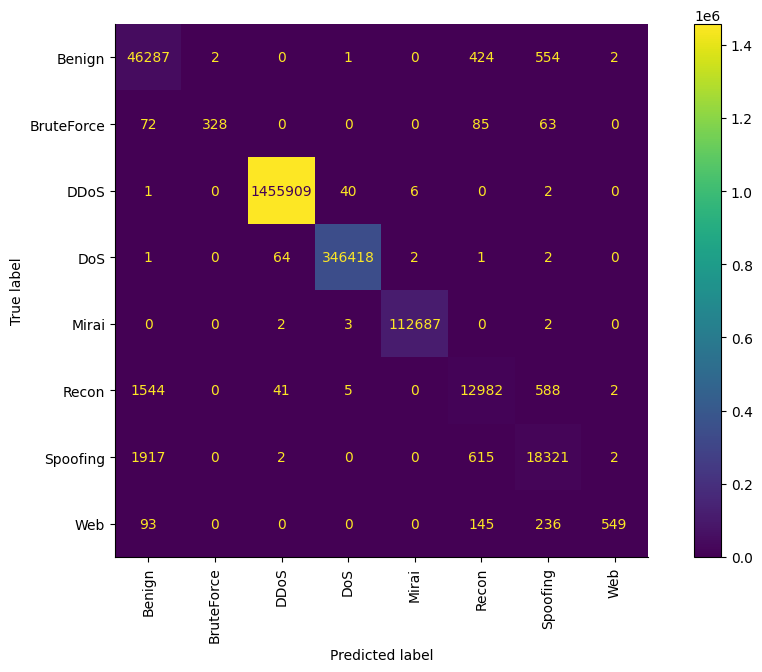

In [45]:
%%time
multi_stage_model = MultiStageClassifier(
    stages=[
        ModelStage(
            model=RandomForestClassifier(max_features=10, class_weight='balanced', n_jobs=n_jobs, random_state=seed),
            labels={'DDoS', 'DoS', 'Mirai'}
        ),
        ModelStage(
            model=RandomForestClassifier(max_features=10, n_jobs=n_jobs, random_state=seed),
            labels={'Spoofing', 'Recon', 'Web', 'BruteForce', 'Benign'}
        ),
    ],
)

model_utils.test_model(multi_stage_model, *multi_stage_df_split)